# **Análise Exploratória de Dados de Logística: Loggi**

## 1\. Contexto

A eficiência logística é crucial para o sucesso de qualquer empresa que lide com entregas e transporte de mercadorias. A Loggi, uma startup inovadora na área de logística, busca constantemente aprimorar seus serviços, garantindo entregas rápidas e confiáveis. Com foco na última milha, a Loggi opera em várias cidades, incluindo Brasília, onde mantém três hubs estrategicamente localizados.

Este projeto de análise exploratória de dados tem como objetivo examinar os padrões de distribuição de entregas nos hubs da Loggi em Brasília. Utilizando dados disponibilizados no repositório Loggi BUD no GitHub, iremos explorar como as entregas estão distribuídas entre os hubs e avaliar se a localização atual dos hubs está otimizada para atender à demanda de forma eficiente.

## 2\. Pacotes e bibliotecas

In [1]:
!pip3 install geopandas;

import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

import json
import os

## 3\. Exploração de dados

Vamos começar baixando os dados brutos e lendo-os com o módulo json para transformá-los em um dicionário.

In [2]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

len(data)

199

Vemos que se trata de um dicionário de tamanho 199. Agora vamos utilizar o módulo pandas para ver mais detalhes.

In [3]:
deliveries_df = pd.DataFrame(data)

deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Agora observamos como o dado está estruturado. Precisamos quebrar os conteúdos das colunas origin e deliveries se quisermos trabalhar com eles. A estrutura de cada ítem do primeiro é de um dicionário, e do segundo é de uma lista de dicionários. Vamos lidar com a coluna origin utilizando uma operação chamada normalize.

In [4]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Transformamos cada dicionário em duas novas colunas, que correspondem a longitude e latitude dos hubs. Agora vamos colocá-las de volta no dataframe original. Também removeremos a antiga coluna origin, e faremos operações para reposicionar e renomear as novas colunas.

In [5]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Agora vamos quebrar a coluna deliveries. Dessa vez utilizaremos a operação explode para quebrar as séries.

In [6]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


Agora temos vários dicionários que correspondem aos índices originais. Vamos normalizar essas estruturas, mas pegando apenas os dados que nos interessam. Não usaremos o mesmo método de antes pois ele não preserva os índices.

Criaremos novos dataframes a partir de cada linha do dataframe explodido. Sobre eles aplicaremos uma função lambda para extrair a coluna de interesse. Renomearemos cada um deles e, por fim, os concatenaremos lado a lado num único dataframe:

In [7]:
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis=1)

deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Agora, de maneira análoga à que fizemos anteriormente, vamos uní-lo ao dataframe original e remover a coluna deliveries. Agora também podemos resetar os índices.

In [8]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [9]:
len(deliveries_df)

636149

Temos o nosso dataframe. Nota-se que seu tamanho agora é bem maior do que os 199 que observamos inicialmente, o que se deve à imensa quantidade de dados aninhados nas colunas que normalizamos. Vamos analisar a sua estrutura.

In [10]:
deliveries_df.shape

(636149, 8)

In [11]:
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [12]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [13]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


Temos uma visão global sobre o tamanho, estrutura e que não temos nenhum dado nulo. Agora vamos ver o schema. Primeiro os tipos:

In [14]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

Atributos categóricos:

In [15]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


Atributos numéricos:

In [16]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes("int64").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


E agora verificaremos que não há dados faltantes:

In [17]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 4\. Manipulação

Agora vamos enriquecer o dataframe. Vamos utilizar algumas operações para obter o nome das regiões às quais as coordenadas correspondem. Iniciaremos com as coordenadas dos hubs.

In [18]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Removemos as duplicatas e ficamos com apenas 3 regiões únicas. Agora vamos utilizar o serviço Nominatim to projeto OpenStreetMap para fazer a geolocalização reversa gratuitamente. As restrições do projeto nos limitam a uma operação por segundo, mas não será problema para tão poucas coordenadas.

In [19]:
geolocator = Nominatim(user_agent="ebac_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Temos os dados na coluna geodata. Vamos normalizá-la.

In [20]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46082661,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46676578,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43508444,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


Agora vamos pegar os dados que nos interessam, que são "town", "suburb" e "city". Vamos também renomear e excluir o que não nos serve, como valores nulos e a coluna de origem.

In [21]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Vamos juntar a este dataframe a coluna de região.

In [22]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


Agora vamos juntar este dataframe ao dataframe principal utilizando a coluna de região como índice, e então rearranjar.

In [23]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Etapa concluída. Agora queremos fazer a geolocalização reversa da entrega, mas é até aqui que podemos ir com a limitação do Nominatim de uma operação por segundo. Mas com a instalação local é possível utilizá-lo sem restrição. Vamos baixar o arquivo processado localmente:

In [24]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")

deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Agora vamos uní-lo ao dataframe principal para obtermos o nosso dataframe enriquecido com geolocalização reversa:

In [25]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Agora nosso dataframe está pronto. Para fins de descobrir a posição ideal dos HUBs de distribuição vamos calcular o centro geométrico das entregas, o centróide. O centróide é a média das coordenadas das entregas. Vamos juntá-las aos seus respectivos pares da coluna de região, mas manteremos num dataframe separado para referência posterior.

In [26]:
centroides_df = deliveries_df.groupby('region').agg({'delivery_lng': 'mean', 'delivery_lat': 'mean'}).reset_index(drop=False)
centroides_df.rename(columns={"delivery_lng": "centroid_lng", "delivery_lat": "centroid_lat"}, inplace=True)

centroides_df.head()

,region,centroid_lng,centroid_lat
0,df-0,-47.765693,-15.664266
1,df-1,-47.893054,-15.801438
2,df-2,-48.056333,-15.857852


Comparando numericamente os centróides e a posição dos seus respectivos hubs vemos uma diferença muito pequena. Mas observar o número das coordenadas sem ver a representação no mapa e sem saber a distancia real não é muito útil. Veremos mais adiante, mas por enquanto vamos analisar a qualidade dos dados do nosso dataframe.

In [27]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


Podemos obeservar que as colunas delivery_city e delivery_suburb tem dados nulos, especialmente o último. O tamanho do nosso arquivo tambem aumentou bastante com os dados extra.

In [28]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

Vamos ver em porcentagem o percentual de dados nulos:

In [29]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [30]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

Uma grande parte da coluna "delivery_suburb" é de valores nulos, então talvez ela não se mostre tão útil. Vamos ver os valores mais comuns dessas duas colunas:

In [31]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

Cerca de 23% dos dados estão como Brasília, o que não nos ajuda, pois Brasília não existe dentro desse contexto. Note que delivery_city se refere às regiões que compõem Brasília. Na coluna "delivery_suburb", que corresponde aos bairros, também temos algumas incidências de "Brasília", mas num percentual menos significante:

In [32]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

## 5\. Visualização

Agora vamos trabalhar na visualização de dados. Primeiro vamos ver como as entregas estão distribuídas. Faremos uma agregação para ver a proporção das entregas por região.


In [33]:
data = pd.DataFrame(deliveries_df[['region']].value_counts(normalize=True)).reset_index()
data.rename(columns={"proportion": "region_percent"}, inplace=True)

data.head()

,region,region_percent
0,df-1,0.478988
1,df-2,0.410783
2,df-0,0.110229


Agora vamos ver como esses dados ficam num gráfico de barras:

/tmp/ipykernel_18/2111424512.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")


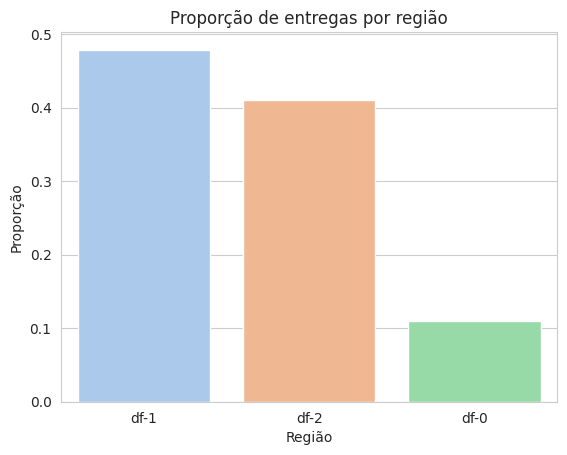

In [34]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

Chama atenção quão pequeno é o percentual da região 0 em comparação com as outras. Isso se deve à densidade populacional.

Agora vamos plotar o gráfico da distribuição das entregas no mapa de Brasília. Primeiro baixaremos o shapefile da cidade de Brasília no site do IBGE, o descompactaremos e pegaremos os dois mapas de interesse:

In [35]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

Vamos pegar apenas a primeira linha, pois é ela que corresponde ao Distrito Federal:

In [36]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Temos o primeiro arquivo POLYGON Z. Agora vamos fazer o mapa dos Hubs. Criaremos coluna geometry com um método do próprio geopandas, onde passamos as informações de latitude e longitude.

In [37]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))

geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


De maneira análoga faremos o mapeamento dos centróides.

In [38]:
geo_centroides_df = geopandas.GeoDataFrame(centroides_df, geometry=geopandas.points_from_xy(centroides_df['centroid_lng'], centroides_df['centroid_lat']))

geo_centroides_df.head()

,region,centroid_lng,centroid_lat,geometry
0,df-0,-47.765693,-15.664266,POINT (-47.76569 -15.66427)
1,df-1,-47.893054,-15.801438,POINT (-47.89305 -15.80144)
2,df-2,-48.056333,-15.857852,POINT (-48.05633 -15.85785)


Por fim, faremos o mapeamento de todas as entregas.

In [39]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))

geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


Com a geometria de todos os mapas em mãos podemos fazer o nosso gráfico. Vamos plotar utilizando matplotlib:

/tmp/ipykernel_18/1747881346.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


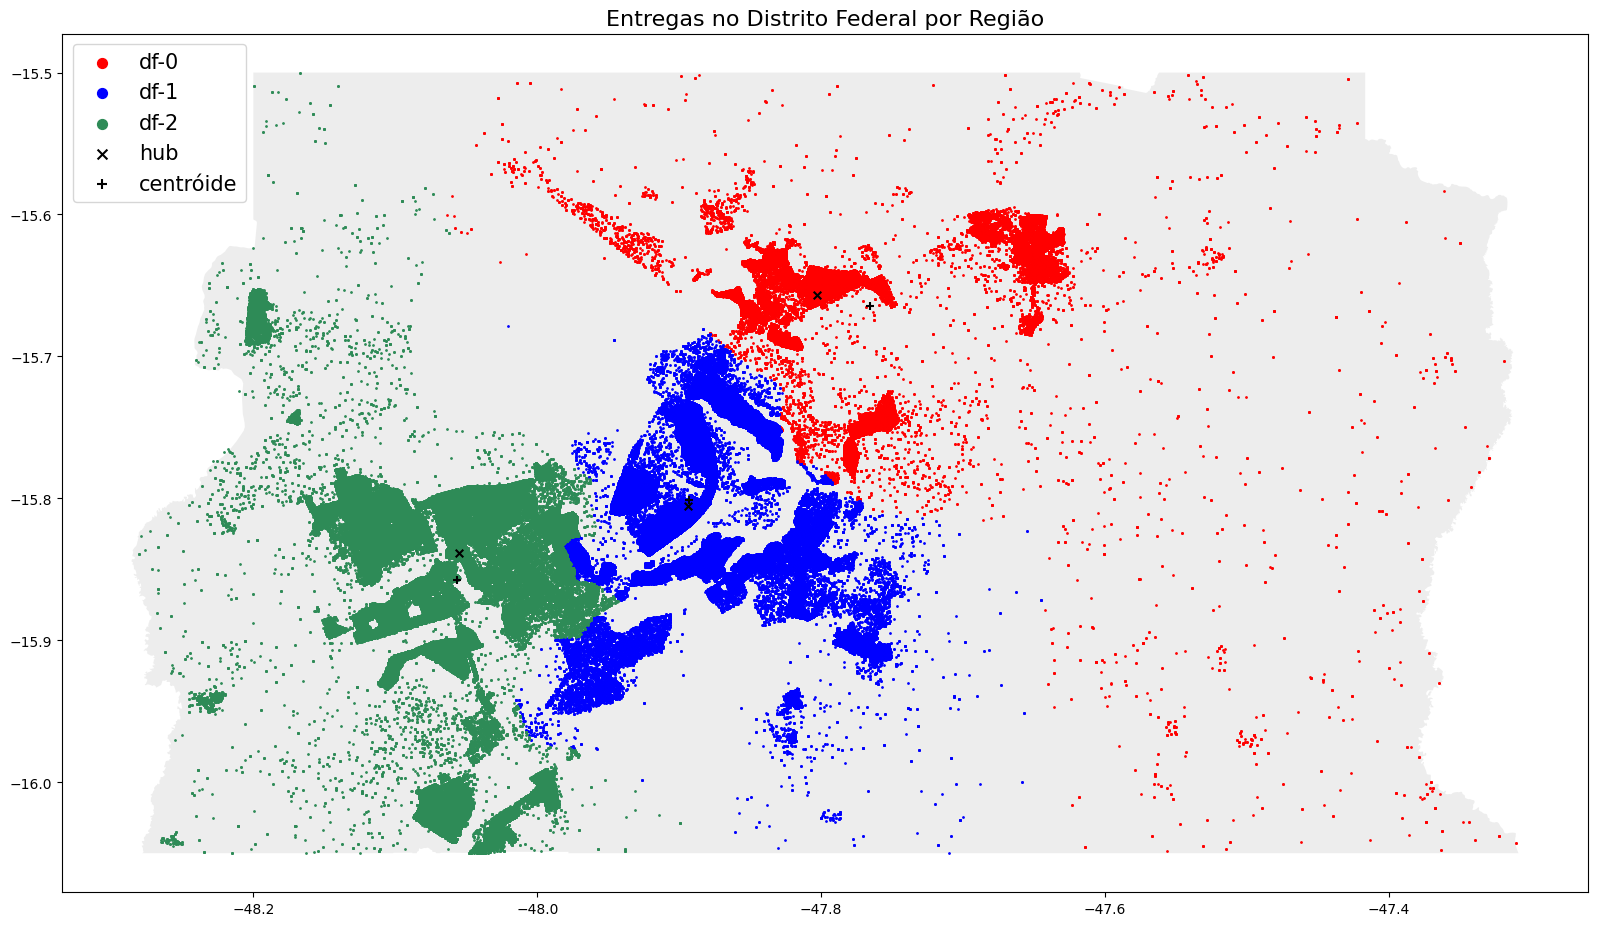

In [40]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot dos centróides
geo_centroides_df.plot(ax=ax, markersize=30, marker="+", color="black", label="centróide")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

Agora podemos visualizar claramente a distribuição das entregas por hub, onde cada ponto colorido representa uma entrega. Os x indicam os hubs e os + representam os centróides das entregas por região.

Observamos que o hub da região 1 (azul) está muito próximo do seu centróide, enquanto os hubs das outras regiões não tanto. Mas antes de tirarmos qualquer conclusão, é essencial determinar as distâncias numéricas entre eles. Vamos calcular essas distâncias usando o método geodesic do geopy.

In [41]:
# Função para calcular a distância entre o hub e o centróide
def calcular_distancia(row):
    centroid_coords = (centroides_df.loc[centroides_df['region'] == row['region'], 'centroid_lat'].values[0], centroides_df.loc[centroides_df['region'] == row['region'], 'centroid_lng'].values[0])
    hub_coords = (row['hub_lat'], row['hub_lng'])
    return geodesic(centroid_coords, hub_coords).kilometers

# Aplicar a função para cada linha do DataFrame e criar um novo DataFrame com os resultados
hub_vs_centroide_df = hub_df[['region']].copy()
hub_vs_centroide_df['distancia_km'] = hub_df.apply(calcular_distancia, axis=1)

hub_vs_centroide_df.head()


,region,distancia_km
0,df-2,2.185556
1,df-1,0.412295
2,df-0,4.044292


Obtemos as distâncias, mas o que elas nos dizem? De modo geral, hubs mais próximos dos centróides podem indicar uma maior eficiência logística, pois os veículos de entrega precisam percorrer distâncias menores para atender às demandas da região. 4km de distância desse ideal teórico pode fazer uma diferença considerável no longo prazo. Mas é essencial considerar também outros fatores, por exemplo, a acessibilidade, a proximidade das principais rotas de transporte, a infraestrutura existente e os custos de mudança. Isso sugere que pode ser benéfico um estudo mais minucioso do reposicionamento do hub, levando em consideração uma gama mais ampla de variáveis e uma profunda análise de custo-benefício.